In [1]:
import jax
import jax.numpy as jnp
import croissant as cro
import croissant.jax as crojax
import matplotlib.pyplot as plt
from functools import partial
from healpy import get_nside, projview
import numpy as np
import lunarsky
import s2fft
import healpy as hp
from lunarsky import Time
from astropy.units import s as seconds

##  Ground Class

32


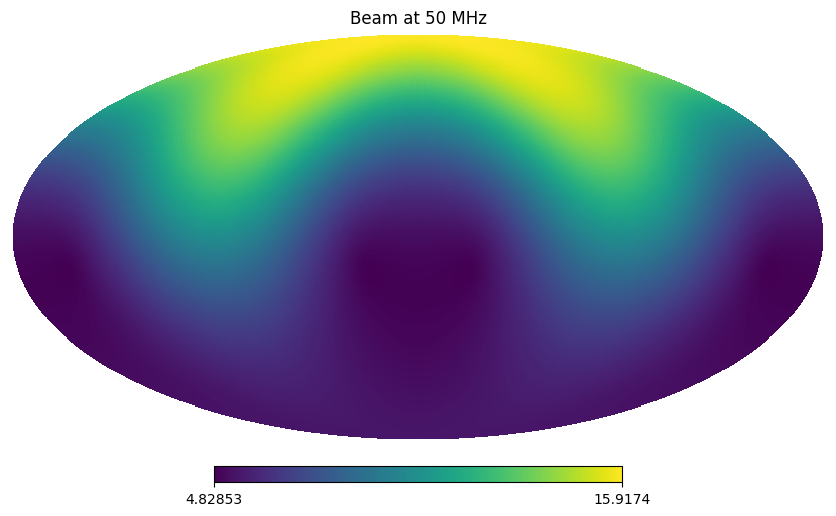

In [4]:
data = np.load('/home/dominiv/simulink/dac/notebooks/eigsep_vivaldi.npz')

bm = data['bm']
freq = data['freqs']/1e6
nside = data['nside']
npix = hp.nside2npix(nside)

lmax = 32

alms = []
for i in range(bm.shape[0]):
    alm = hp.map2alm(bm[i], lmax = 32)
    alms.append(alm)
alms = np.array(alms)

beam_alm = alms
beam = cro.Beam(beam_alm, lmax=lmax, frequencies=freq, coord="T")
print(beam.lmax)
beam[:, 0, 0] = 30 * (freq/freq[0]) ** 2
beam[:, 1, 0] = 10 * (freq/freq[0])**2
# visualize with healpix
hp.mollview(beam.hp_map(nside)[0], title=f"Beam at {freq[0]:.0f} MHz")

In [5]:
# dac is a number that will change the ground temp by that much at theta and phi
# spread is the dac temp spreading out at both position and frequency (later replace with its own beam?)
# other arguments are the same as the sky class
class Ground(cro.Alm):
    @classmethod
    def ground(cls, freq, temp, nside=64,lmax=32, dac=None, spread=None):
        npix = hp.nside2npix(nside)
        freq = np.array(freq)
        theta=np.pi
        phi=2*np.pi
        m = np.full((int(freq.shape[0]), npix), temp)
        if dac != None:
            dac_freq = dac[0]
            dac_temp = dac[1]
            new_ind = hp.ang2pix(nside, theta, phi)
            print(new_ind)
            limit = int(m.shape[0])
            m[dac_freq][new_ind] += dac_temp
            # for j in range(limit):
                # m[j][new_ind] += dac
        if spread != None:
            vec = hp.ang2vec(theta,phi)
            surround = np.array(hp.query_disc(nside, vec, radius=np.radians(spread)))
            # print(surround)
            place_holder = 30 # Will depend on beam and DAC I think, frequency range surrounding target freq from DAC
            for i in range(place_holder+1):
                for k in surround:
                    if i == 0 and k == new_ind:
                        continue
                    if i == 0:
                        m[dac_freq][k] += dac_temp/2
                    else:
                        m[dac_freq+i][k] += dac_temp/2
                        m[dac_freq-i][k] += dac_temp/2
            print('center', m[dac_freq][new_ind])
            print('surrounding', m[dac_freq][new_ind-1],m[dac_freq][new_ind+1])
        alms = []
        print(m.shape)
        for i in range(m.shape[0]):
            alm = hp.map2alm(m[i], lmax=lmax)
            alms.append(alm)
        m = np.array(alms)
        print(m[0].shape)

        # m = hp.map2alm(m, lmax=lmax)
        obj = cls(
            m,
            frequencies=freq,
            coord='G'
        )
        return obj

49148
center 350
surrounding 325 325
(201, 49152)
(561,)


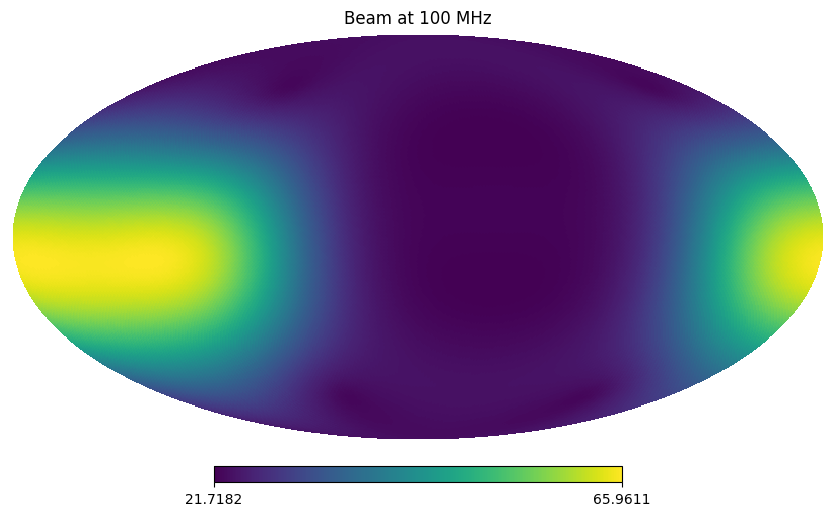

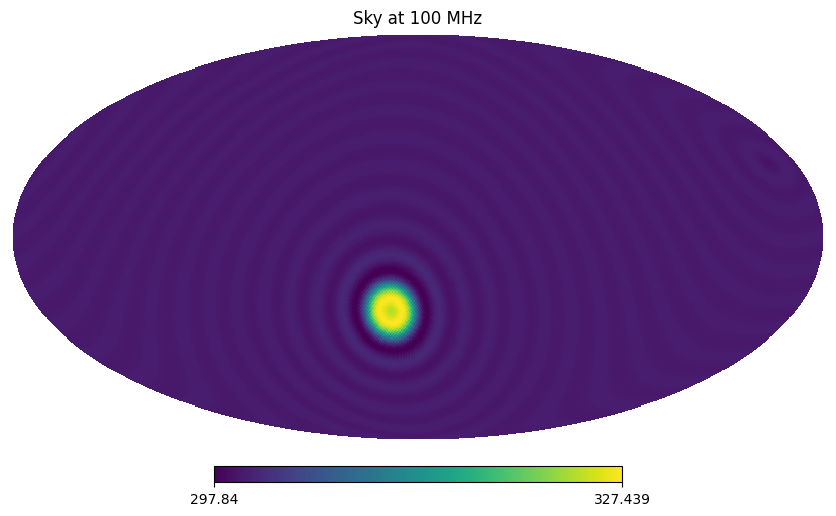

In [6]:
g = Ground.ground(beam.frequencies, 300, dac=(50,50), spread=10)
# baby_dac(g, np.pi/2, 2*np.pi, 50, spread=10)

loc = (20., -10.)
t_start = Time("2022-06-02 15:43:43")
t_end = t_start + cro.constants.sidereal_day_earth * seconds
times = cro.utils.time_array(t_start=t_start, t_end=t_end, N_times=300)
sim = cro.Simulator(beam, g, lmax=lmax, world="earth", location=loc, times=times)

wanted_ind = 50
hp.mollview(sim.beam.hp_map(nside)[wanted_ind], title=f"Beam at {freq[wanted_ind]:.0f} MHz")
hp.mollview(sim.sky.hp_map(nside)[wanted_ind], title=f"Sky at {freq[wanted_ind]:.0f} MHz")

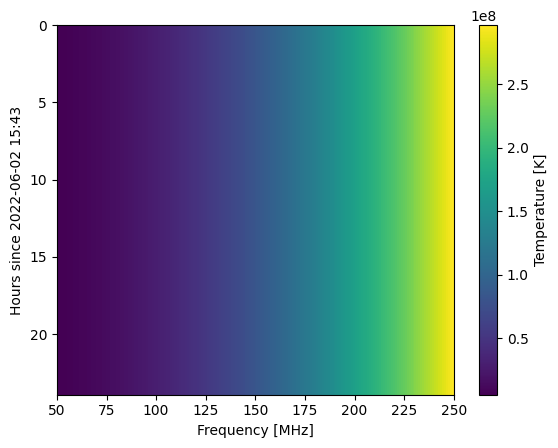

In [7]:
sim.run(dpss=True, nterms=40)
sim.plot(power=2.5)

## Gradient Descent

In [9]:
# so far the function compares a "measured" waterfall at every frequency with a "known" waterfall
# right now, if loss is positive, function converges, when negative it diverges
# i think having it add param to measured instead of subtract in this case would fix it
param = 10
learning_rate = .001
loops = 500

def fitting(known, measured, temp, param, learning_rate, loops):
    def beam_descend(temp, param, learning_rate):
        temp_grad = 0
        N = temp.shape[0]
        temp_grad = jnp.gradient(temp)
        param = param - learning_rate*(1/N)*temp_grad
        return param

    def loss_func(known, measured):
        loss = jnp.divide(jnp.sum((known-measured)**2, axis=0), measured.shape[0])
        return loss


    for i in range(loops):
        param = beam_descend(temp, param, learning_rate)
        measured -= param
        loss = loss_func(known, measured)
                
        if jnp.abs(loss) < 1:
            print('')
            print(f'minimized loss to: {loss}')
            print(f'best param for every frequency: {param}')
            break
        print(f'{i}: loss: {loss}')

    return param

# temp_adj = fitting(known[:][0], observed[:][0], observed[:][0], 10, .001, 500)